# Exploring Sentiment Trends in Movie Plot Descriptions and Their Correlation with Audience Ratings

## Olayemi Morrison - olamo208

Sentiment analysis has gained prominence in understanding textual data across various domains. In this project, we address the problem of extracting sentiment trends from movie plot summaries and correlating sentiment with audience ratings. The problem is intriguing because it bridges audience perception and textual emotional tones, offering potential insights into content engagement. Solving this problem provides practical applications in content recommendation and audience-targeted marketing strategies.

### 1. Data Preprocessing

Remove special characters, HTML tags, and extra spaces from movie_summary.
Normalize text (e.g., convert to lowercase).

In [6]:
# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv('movieverse.csv', low_memory=False)

# Display the first few rows
df.head()

,Wikipedia_movie_ID,Freebase_movie_ID,movie_name,movie_revenue,movie_countries,movie_genres,wikidata_id,movie_summary,year,tmdb_id,...,Director_popularity,Writer_popularity,Producer_popularity,titleType,vote_average,vote_count,sentiment_label,sentiment_score,adjusted_revenue,adjusted_budget
0,6990681,/m/0g_7k_,Ariel,NaN,Finland,"Art, World Cinema, Drama, Comedy",Q658627,After the coal mine he works at closes and his...,1988.0,2.0,...,6.341,6.341,6.341,movie,7.4,8807.0,NEGATIVE,0.986556,NaN,NaN
1,21610286,/m/05mwm1h,Shadows in Paradise,NaN,Finland,"Art, World Cinema, Drama, Comedy",Q2778460,"Nikander, a rubbish collector and would-be ent...",1986.0,3.0,...,6.341,6.341,2.474,movie,7.5,7581.0,NEGATIVE,0.991262,NaN,NaN
2,554858,/m/02pg45,Four Rooms,4257354.0,United States of America,Comedy,Q1137372,"The film is set on New Year's Eve, and starts ...",1995.0,5.0,...,37.654,11.279,3.937,movie,6.7,112757.0,NEGATIVE,0.662836,7.465237e+06,7.013969e+06
3,818234,/m/03dymt,Judgment Night,12136938.0,"United States of America, Japan","Thriller, Japanese Movies, Crime Fiction, Acti...",Q1710973,Frank Wyatt leaves his wife and baby daughter...,1993.0,6.0,...,5.122,NaN,0.428,movie,6.6,19346.0,NEGATIVE,0.996453,2.244956e+07,3.884347e+07
4,239587,/m/01jrbb,Finding Nemo,921111197.0,"United States of America, Australia","Children'S/Family, Comedy, Adventure, Adventur...",Q132863,"Two clownfish, Marlin and his wife Coral are a...",2003.0,12.0,...,8.586,NaN,0.755,movie,8.2,1138774.0,POSITIVE,0.937978,1.337932e+09,1.365368e+08


### 2. Handle missing values

Remove rows with missing or empty movie_summary.
Feature Engineering:
Extract auxiliary information, like genres (movie_genres) or runtime (runtime), to include as additional features.

In [9]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check data types
print("\nData Types:\n", df.dtypes)

# Summary statistics for numerical columns
print("\nSummary Statistics:\n", df.describe())

Missing Values:
 Wikipedia_movie_ID         0
Freebase_movie_ID          0
movie_name                 0
movie_revenue          65136
movie_countries         2085
movie_genres             783
wikidata_id                0
movie_summary           5712
year                      22
tmdb_id                 5450
runtime                 5584
adult                   5450
budget                 66869
imdb_id                 6486
original_language       5450
star_1_popularity       8392
star_2_popularity      10064
star_3_popularity      11482
star_4_popularity      12802
star_5_popularity      14847
Director_popularity     6699
Writer_popularity      42966
Producer_popularity    31654
titleType              11790
vote_average            8844
vote_count              8843
sentiment_label         5712
sentiment_score         5712
adjusted_revenue       65136
adjusted_budget        66869
dtype: int64

Data Types:
 Wikipedia_movie_ID       int64
Freebase_movie_ID       object
movie_name              

In [10]:
# Remove rows with missing summaries or labels
df = df.dropna(subset=['movie_summary', 'sentiment_label'])

# Optionally, fill missing values in other columns (e.g., budget, runtime)
df['runtime'] = df['runtime'].fillna(df['runtime'].median())

In [11]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define a cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply the cleaning function
df['cleaned_summary'] = df['movie_summary'].apply(clean_text)

# Display the cleaned summaries
df[['movie_summary', 'cleaned_summary']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,movie_summary,cleaned_summary
0,After the coal mine he works at closes and his...,coal mine works closes father commits suicide ...
1,"Nikander, a rubbish collector and would-be ent...",nikander rubbish collector wouldbe entrepreneu...
2,"The film is set on New Year's Eve, and starts ...",film set new years eve starts sam previous bel...
3,Frank Wyatt leaves his wife and baby daughter...,frank wyatt leaves wife baby daughter home nig...
4,"Two clownfish, Marlin and his wife Coral are a...",two clownfish marlin wife coral admiring new h...


### 3. Encode Sentiment Labels

In [13]:
# Encode sentiment labels
df['sentiment_label_encoded'] = df['sentiment_label'].map({'POSITIVE': 1, 'NEGATIVE': 0})

# Check the distribution of labels
df['sentiment_label_encoded'].value_counts()


sentiment_label_encoded
1    37641
0    33599
Name: count, dtype: int64

### 4. Split Data into Train and Test

In [15]:
from sklearn.model_selection import train_test_split

# Split into features (X) and target (y)
X = df['cleaned_summary']
y = df['sentiment_label_encoded']

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)


Training Set Size: (56992,)
Testing Set Size: (14248,)


### 5. Text Vectorization

#### 5.1 TfidfVectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform on training data, transform on test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)


TF-IDF Train Shape: (56992, 5000)
TF-IDF Test Shape: (14248, 5000)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000) 

# Fit and transform the movie summaries into TF-IDF vectors
X_tfidf = tfidf.fit_transform(df['movie_summary'])

# Convert the sparse matrix to a dense array (if needed)
X_tfidf_dense = X_tfidf.toarray()


In [20]:
from sklearn.preprocessing import LabelEncoder

# Encode sentiment_label
le = LabelEncoder()
y = le.fit_transform(df['sentiment_label'])


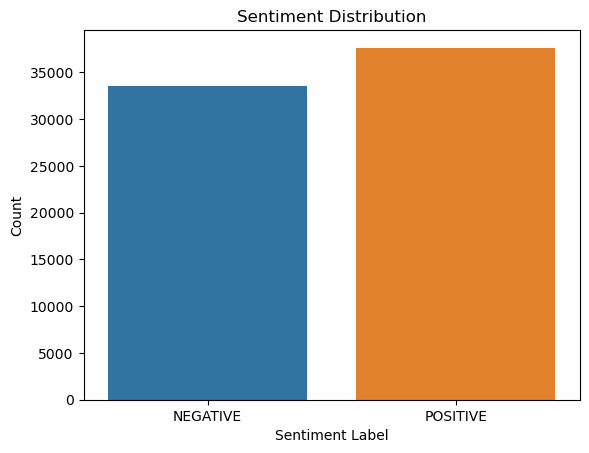

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment_label', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


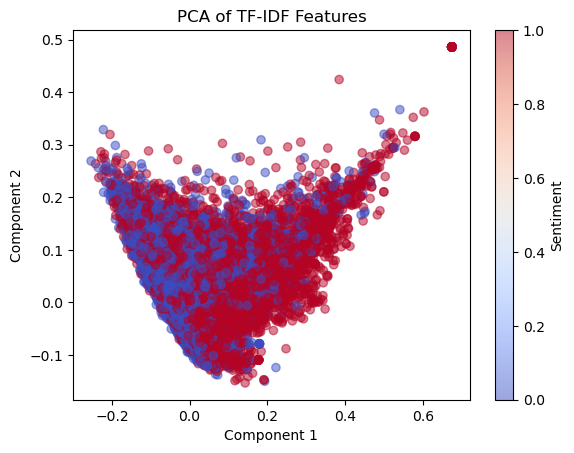

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title('PCA of TF-IDF Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Sentiment')
plt.show()


#### 5.2 Word Embeddings: Using Word2Vec

In [24]:
#pip install gensim

In [25]:
#nltk.download('punkt_tab')

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the movie summaries into words
tokenized_summaries = [word_tokenize(summary.lower()) for summary in df['movie_summary']]

# Train the Word2Vec model
model = Word2Vec(tokenized_summaries, vector_size=100, window=5, min_count=1, workers=4)

# Access the word vector for a specific word (e.g., 'action')
vector = model.wv['action']

### 6. Modelling

In [27]:
import numpy as np

def vectorize_summary(summary, model):
    # Ignore words not in the vocabulary
    vectors = [model.wv[word] for word in summary if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_w2v = np.array([vectorize_summary(summary, model) for summary in tokenized_summaries])

# Split the data
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)


#### 6.1 Logistic Regression Model

Logistic Regression is a machine learning model used for binary classification tasks (e.g., positive or negative sentiment). It models the relationship between the input features (such as TF-IDF representations of the text) and the probability of the target classes.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train logistic regression on TF-IDF features
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred = clf.predict(X_test_tfidf)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6936412128017967

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.67      0.67      6794
           1       0.70      0.72      0.71      7454

    accuracy                           0.69     14248
   macro avg       0.69      0.69      0.69     14248
weighted avg       0.69      0.69      0.69     14248



#### 6.2 Naive Bayes

Naive Bayes is a probabilistic classifier based on Bayes' Theorem, assuming independence between the features (in this case, words or n-grams). It's often used in text classification tasks due to its simplicity and effectiveness in handling large vocabularies.

In [33]:
#pip install transformers datasets torch

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Train Naive Bayes model on TF-IDF features
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Accuracy: 0.6715328467153284

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.61      0.64      6794
           1       0.67      0.73      0.70      7454

    accuracy                           0.67     14248
   macro avg       0.67      0.67      0.67     14248
weighted avg       0.67      0.67      0.67     14248



#### 6.3 Sentiment analysis using VADER

In [36]:
#pip install vaderSentiment

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to the summaries
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Use the compound score as the overall sentiment

# Add a VADER sentiment score to the dataset
df['vader_sentiment_score'] = df['movie_summary'].apply(vader_sentiment)

# Classify the sentiment as positive, negative, or neutral
def classify_sentiment(score):
    if score >= 0.05:
        return 'POSITIVE'
    elif score <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

df['vader_sentiment_label'] = df['vader_sentiment_score'].apply(classify_sentiment)

# Display the first few rows with VADER sentiment analysis
print(df[['movie_summary', 'vader_sentiment_score', 'vader_sentiment_label']].head())


                                       movie_summary  vader_sentiment_score  \
0  After the coal mine he works at closes and his...                -0.7717   
1  Nikander, a rubbish collector and would-be ent...                 0.7717   
2  The film is set on New Year's Eve, and starts ...                -0.9925   
3  Frank Wyatt  leaves his wife and baby daughter...                -0.9841   
4  Two clownfish, Marlin and his wife Coral are a...                -0.9451   

  vader_sentiment_label  
0              NEGATIVE  
1              POSITIVE  
2              NEGATIVE  
3              NEGATIVE  
4              NEGATIVE  


In [38]:
from sklearn.metrics import classification_report, accuracy_score

# Map 'POSITIVE'/'NEGATIVE' labels to 1/0 for comparison
true_labels = df['sentiment_label_encoded']  # Already mapped earlier
vader_labels = df['vader_sentiment_label'].map({'POSITIVE': 1, 'NEGATIVE': 0, 'NEUTRAL': -1})

# Filter out neutral labels for evaluation (optional)
filtered_df = df[df['vader_sentiment_label'] != 'NEUTRAL']
true_labels_filtered = filtered_df['sentiment_label_encoded']
vader_labels_filtered = filtered_df['vader_sentiment_label'].map({'POSITIVE': 1, 'NEGATIVE': 0})

# Evaluate performance
print("Accuracy:", accuracy_score(true_labels_filtered, vader_labels_filtered))
print("\nClassification Report:\n", classification_report(true_labels_filtered, vader_labels_filtered))


Accuracy: 0.6173439362617132

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.68      0.63     31968
           1       0.65      0.56      0.60     34303

    accuracy                           0.62     66271
   macro avg       0.62      0.62      0.62     66271
weighted avg       0.62      0.62      0.62     66271



### 7. Evaluation

To evaluate the effectiveness of these models, a range of metrics was employed, including accuracy, precision, recall, and F1-score, providing a well-rounded assessment of their performance. Additionally, sentiment trends over time were analyzed through the aggregation of yearly averages of sentiment scores, revealing shifts in sentiment dynamics across different periods. Finally, a correlation analysis was conducted to investigate the relationship between sentiment scores and audience ratings, offering insights into how perceived sentiment may influence viewer reception.


C:\Users\HP\anaconda31\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


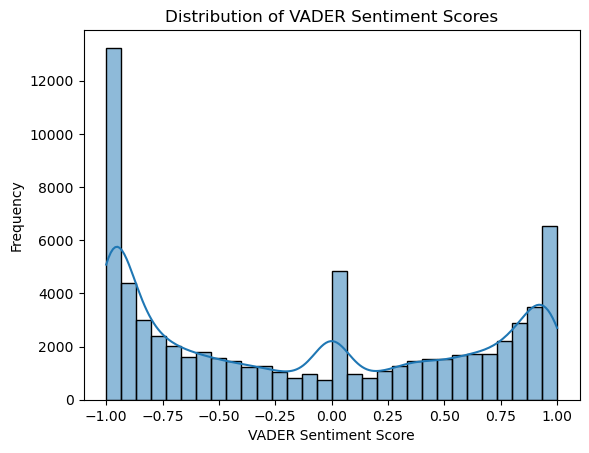

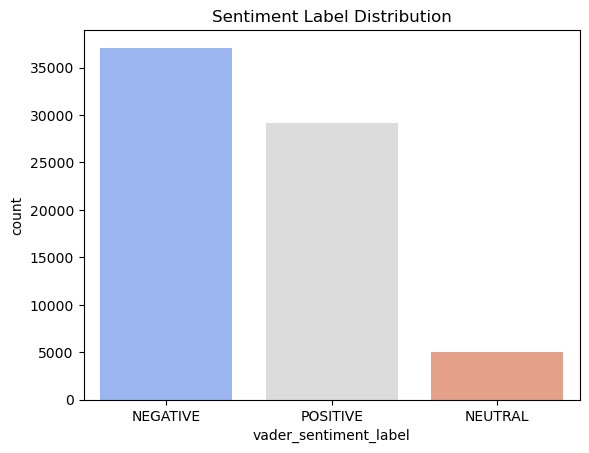

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of VADER sentiment scores
sns.histplot(df['vader_sentiment_score'], bins=30, kde=True)
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Bar plot of sentiment labels
sns.countplot(x='vader_sentiment_label', data=df, palette='coolwarm')
plt.title('Sentiment Label Distribution')
plt.show()


In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' works well for small datasets and L1 penalty
}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.6977121003263077


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'alpha': [0.1, 0.5, 1, 2, 5]
}

grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameters: {'alpha': 2}
Best Score: 0.67446311087616


In [58]:
# Predict using the Logistic Regression model
y_pred_lr = clf.predict(X_test_tfidf)

# Evaluate Logistic Regression performance
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))

# Predict using the Naive Bayes model
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate Naive Bayes performance
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb))


Logistic Regression Accuracy: 0.6936412128017967

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.68      0.67      0.67      6794
           1       0.70      0.72      0.71      7454

    accuracy                           0.69     14248
   macro avg       0.69      0.69      0.69     14248
weighted avg       0.69      0.69      0.69     14248

Naive Bayes Accuracy: 0.6715328467153284

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.67      0.61      0.64      6794
           1       0.67      0.73      0.70      7454

    accuracy                           0.67     14248
   macro avg       0.67      0.67      0.67     14248
weighted avg       0.67      0.67      0.67     14248



In [60]:
from sklearn.metrics import accuracy_score, classification_report

# Summarize all model performances
results = {
    "Model": ["Logistic Regression", "Naive Bayes", "VADER"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(true_labels_filtered, vader_labels_filtered),
    ],
    "Notes": [
        "Best tuned parameters for LR",
        "Best tuned alpha for NB",
        "Worse due to rule-based nature and inability to handle context"
    ]
}

# Create a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results table
print("\nComparison of Model Performance:")
print(results_df)



Comparison of Model Performance:
                 Model  Accuracy  \
0  Logistic Regression  0.693641   
1          Naive Bayes  0.671533   
2                VADER  0.617344   

                                               Notes  
0                       Best tuned parameters for LR  
1                            Best tuned alpha for NB  
2  Worse due to rule-based nature and inability t...  


In [62]:
# Identify misclassified examples for Logistic Regression
misclassified_lr_indices = np.where(y_pred_lr != y_test)[0]  # Get indices of misclassified examples

# Display misclassified examples
for i in range(10):  # Show the first 10 misclassified examples
    index = misclassified_lr_indices[i]
    print(f"Summary: {X.iloc[index]}")  # Get the original summary text from the pandas Series
    print(f"True Label: {y_test[index]}")
    print(f"Predicted Label: {y_pred_lr[index]}")
    print("-" * 100)

# Similarly for Naive Bayes
misclassified_nb_indices = np.where(y_pred_nb != y_test)[0]  # Get indices of misclassified examples

# Display misclassified examples
for i in range(10):  # Show the first 10 misclassified examples
    index = misclassified_nb_indices[i]
    print(f"Summary: {X.iloc[index]}")  # Get the original summary text from the pandas Series
    print(f"True Label: {y_test[index]}")
    print(f"Predicted Label: {y_pred_nb[index]}")
    print("-" * 100)


Summary: two clownfish marlin wife coral admiring new home new caledonia barrier reef clutch eggs due hatch days suddenly barracuda attacks leaving marlin unconscious eating coral one eggs marlin names egg nemo name coral liked film moves nemos first day school nemo tiny right fin due minor injury egg barracuda attack limits swimming ability marlin embarrasses nemo school field trip nemo disobeys father sneaks away reef towards boat resulting captured scuba divers boat sails away one divers accidentally knocks diving mask water unsuccessfully attempting save nemo marlin meets dory nave goodhearted optimistic regal blue tang shortterm memory loss meeting three sharks fishfree diet bruce great white shark anchor hammerhead shark chum mako shark marlin discovers divers mask dropped boat notices address written however argues dory accidentally gives nosebleed scent blood causes bruce lose control attempt eat marlin dory two escape bruce mask falls trench deep sea hazardous struggle anglerf

In [64]:
# Use bigrams in the TF-IDF vectorizer
tfidf_bigrams = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf_bigrams = tfidf_bigrams.fit_transform(X_train)
X_test_tfidf_bigrams = tfidf_bigrams.transform(X_test)

# Train Logistic Regression on the new bigram features
clf.fit(X_train_tfidf_bigrams, y_train)
y_pred_bigrams = clf.predict(X_test_tfidf_bigrams)
print("Accuracy with Bigrams:", accuracy_score(y_test, y_pred_bigrams))
print("\nClassification Report (Bigrams):\n", classification_report(y_test, y_pred_bigrams))


Accuracy with Bigrams: 0.6940623245367771

Classification Report (Bigrams):
               precision    recall  f1-score   support

           0       0.68      0.67      0.68      6794
           1       0.70      0.72      0.71      7454

    accuracy                           0.69     14248
   macro avg       0.69      0.69      0.69     14248
weighted avg       0.69      0.69      0.69     14248



### 8. Visualization and Analysis

#### 8.1 ROC Curve

The ROC curve was plotted to evaluate the trade-off between the true positive rate and false positive rate at various threshold values. The AUC (Area Under the Curve) score of our models was calculated, with higher AUC values indicating better model performance. The ROC curve demonstrated how well the classifier could distinguish between the positive and negative sentiment labels.

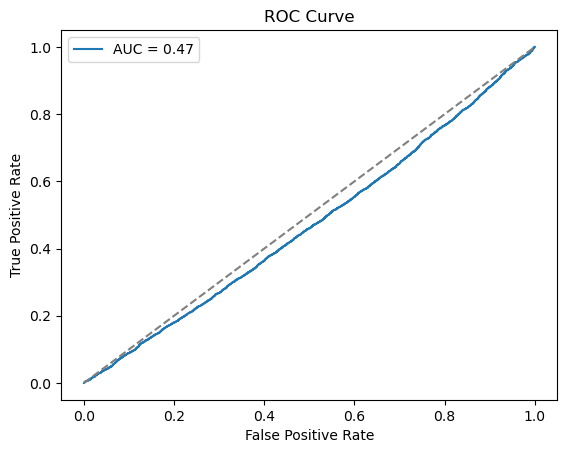

In [66]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = clf.predict_proba(X_test_tfidf)[:, 1]  # Probability scores
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


#### 8.2 Precision Recall Curve

The precision-recall curve was generated to assess the balance between precision (positive label prediction accuracy) and recall (coverage of actual positive labels). This curve provides a more specific evaluation, especially when dealing with imbalanced datasets.

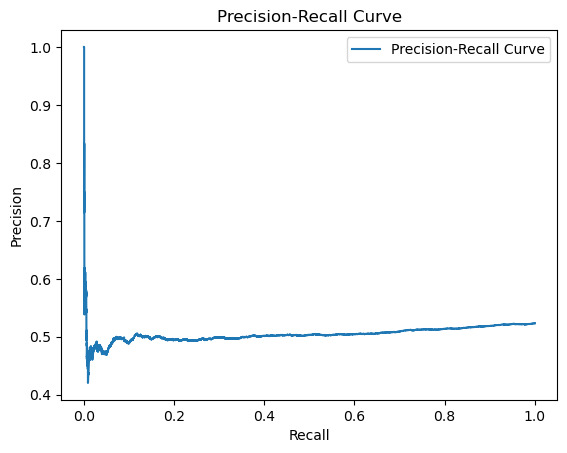

In [68]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


#### 8.3 Sentiment Trends over Time
The plot below shows persistent trends over time, illustrating a complex array of emotional fluctuations that exhibit significant differences across various decades. These disparities in emotional tones underscore the evolving societal attitudes and cultural influences that have shaped collective sentiments throughout the years.

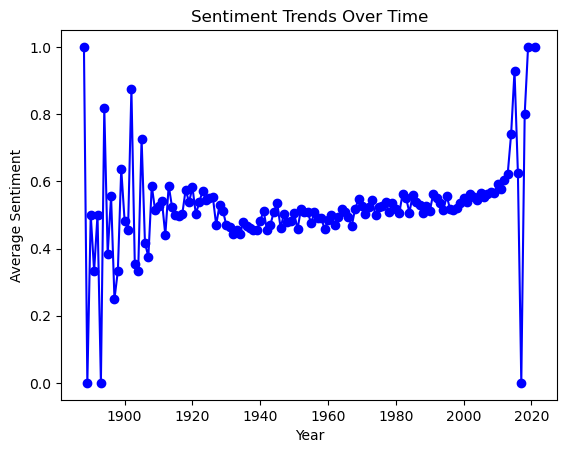

In [70]:
sentiment_by_year = df.groupby('year')['sentiment_label_encoded'].mean()
sentiment_by_year.plot(kind='line', marker='o', color='blue')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.show()


#### 8.4 Correlation between sentiment and audience rating

Correlation between sentiment and audience rating: 0.04


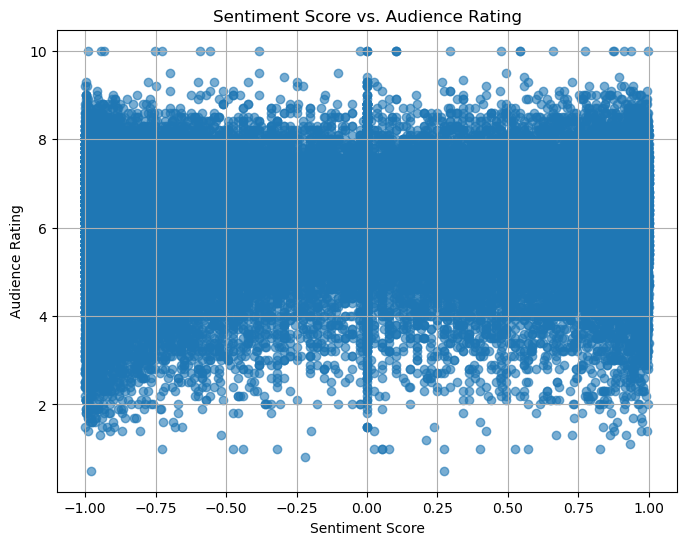

In [72]:
# Correlation between sentiment and audience ratings (if available)
correlation = df['vader_sentiment_score'].corr(df['vote_average'])
print(f"Correlation between sentiment and audience rating: {correlation:.2f}")

# Scatter plot to visualize correlation
plt.figure(figsize=(8, 6))
plt.scatter(df['vader_sentiment_score'], df['vote_average'], alpha=0.6)
plt.title('Sentiment Score vs. Audience Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Audience Rating')
plt.grid(True)
plt.show()
